In [1]:
import zipfile
import os

def extract_zip(zip_path, extract_to):
    """
    Extract a zip file to a target directory.

    Args:
        zip_path (str): Path to .zip file
        extract_to (str): Directory to extract contents into
    """
    if not os.path.exists(zip_path):
        raise FileNotFoundError(f"Zip file not found: {zip_path}")

    os.makedirs(extract_to, exist_ok=True)

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

    print(f" Extracted '{zip_path}' to '{extract_to}'")

    # Optional: show top-level structure
    for root, dirs, files in os.walk(extract_to):
        print("📁", root)
        for d in dirs:
            print("  ├─", d)
        for f in files[:5]:
            print("  └─", f)
        break


In [4]:
extract_zip("/content/archive (1).zip",
            "/content/Wbc")

✅ Extracted '/content/archive (1).zip' to '/content/Wbc'
📁 /content/Wbc
  ├─ original_images
  ├─ binary_masks


In [12]:
import os, glob
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset

def _resolve_nested(root_dir, folder_name):
    """
    Handles cases like:
      root_dir/folder_name/...
    or
      root_dir/folder_name/folder_name/...
    Returns the deepest valid folder that contains class subfolders.
    """
    p1 = os.path.join(root_dir, folder_name)
    p2 = os.path.join(p1, folder_name)

    def has_subdirs(p):
        return os.path.isdir(p) and any(os.path.isdir(os.path.join(p, d)) for d in os.listdir(p))

    # Prefer the deeper nested one if it exists and has subdirs
    if has_subdirs(p2):
        return p2
    if has_subdirs(p1):
        return p1

    raise FileNotFoundError(f"Could not resolve {folder_name} under {root_dir}. Checked: {p1} and {p2}")

class WBCBinarySegDataset(Dataset):
    """
    Pairs:
      image_root/<class_name>/<file>
      mask_root/<class_name>/<file>
    with same filename.
    """
    def __init__(self, root_dir, image_folder="original_images", mask_folder="binary_masks"):
        self.root_dir = root_dir
        self.image_root = _resolve_nested(root_dir, image_folder)
        self.mask_root  = _resolve_nested(root_dir, mask_folder)

        # class folders come from image_root
        self.class_names = sorted([
            d for d in os.listdir(self.image_root)
            if os.path.isdir(os.path.join(self.image_root, d))
        ])

        exts = ["png","jpg","jpeg","tif","tiff","bmp"]
        self.samples = []

        for cname in self.class_names:
            img_dir = os.path.join(self.image_root, cname)
            msk_dir = os.path.join(self.mask_root, cname)

            # collect images (case-insensitive)
            img_paths = []
            for e in exts:
                img_paths += glob.glob(os.path.join(img_dir, f"*.{e}"))
                img_paths += glob.glob(os.path.join(img_dir, f"*.{e.upper()}"))
            img_paths = sorted(img_paths)

            for img_path in img_paths:
                fname = os.path.basename(img_path)
                mask_path = os.path.join(msk_dir, fname)
                if not os.path.exists(mask_path):
                    raise FileNotFoundError(f"Missing mask: expected {mask_path} for image {img_path}")
                self.samples.append((img_path, mask_path, cname))

        if len(self.samples) == 0:
            raise RuntimeError("No samples found even after resolving nested folders.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, mask_path, cname = self.samples[idx]

        image = Image.open(img_path).convert("RGB")

        mask = Image.open(mask_path)
        mask_np = np.array(mask)
        if mask_np.ndim == 3:
            mask_np = mask_np[..., 0]
        mask_np = (mask_np > 0).astype(np.int64)  # binary {0,1}
        mask_t = torch.from_numpy(mask_np)        # (H, W) long

        meta = {"img_path": img_path, "mask_path": mask_path, "class_name": cname}
        return image, mask_t, meta


In [13]:
root_dir = "/content/Wbc"
ds = WBCBinarySegDataset(root_dir=root_dir)

print("Num samples:", len(ds))
print("Classes:", ds.class_names[:20])
print("Example sample:", ds.samples[0])


Num samples: 1560
Classes: ['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']
Example sample: ('/content/Wbc/original_images/original_images/basophil/BA_102039.jpg', '/content/Wbc/binary_masks/binary_masks/basophil/BA_102039.jpg', 'basophil')


In [15]:
import matplotlib.pyplot as plt
import numpy as np

def show_multiple_samples(dataset, indices=None, n=6):
    """
    Show multiple image–mask pairs.
    Mask is shown as black (0) / white (1).
    """
    if indices is None:
        indices = list(range(min(n, len(dataset))))

    n = len(indices)
    plt.figure(figsize=(8, 3 * n))

    for i, idx in enumerate(indices):
        img, mask, meta = dataset[idx]

        img_np = np.array(img)
        mask_np = mask.numpy()

        # Image
        plt.subplot(n, 2, 2*i + 1)
        plt.title(f"Image | {meta['class_name']}")
        plt.imshow(img_np)
        plt.axis("off")

        # Mask (force black & white)
        plt.subplot(n, 2, 2*i + 2)
        plt.title("Mask (binary)")
        plt.imshow(mask_np, cmap="gray", vmin=0, vmax=1)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


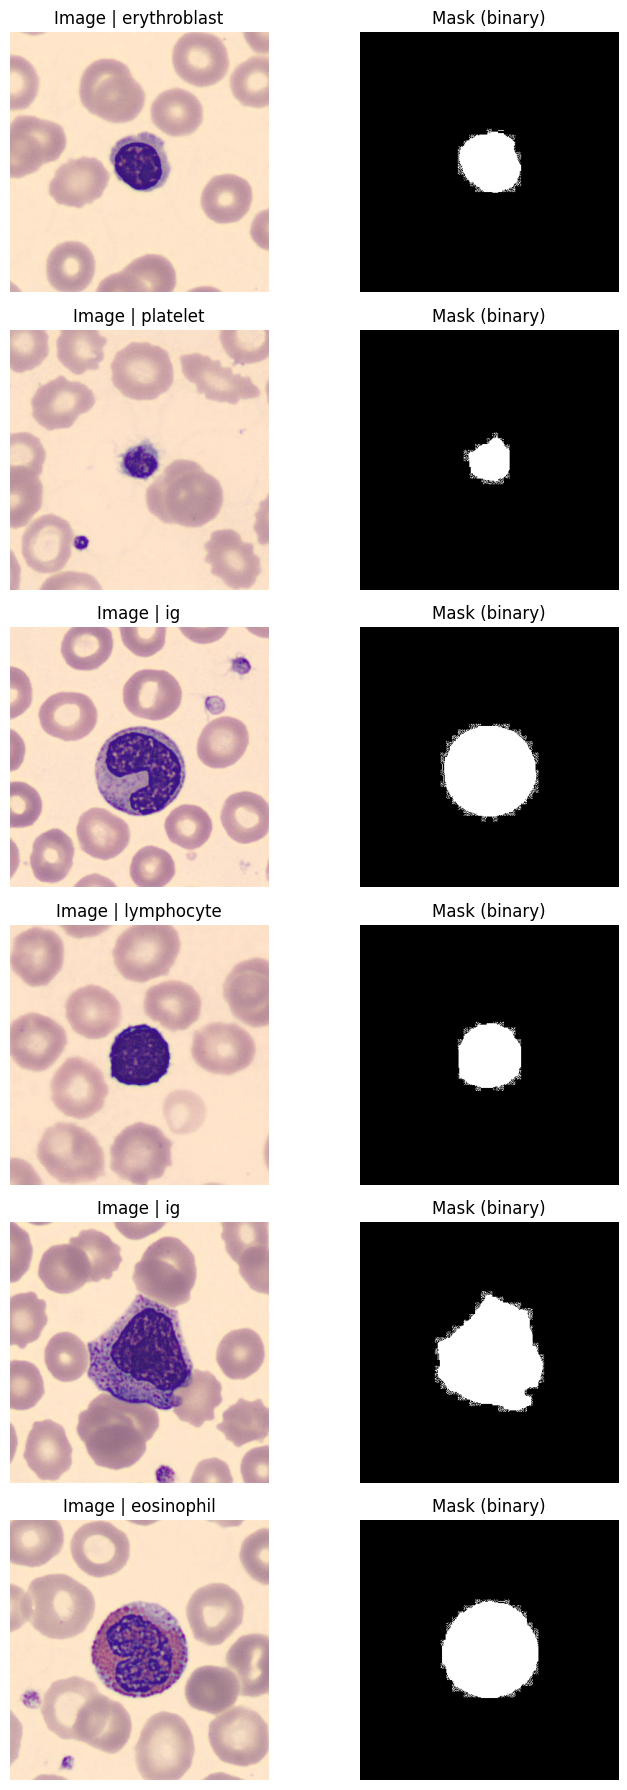

In [16]:
import random
idxs = random.sample(range(len(ds)), 6)
show_multiple_samples(ds, indices=idxs)


In [17]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Subset

# --------- split: 60/20/20 ----------
def split_indices(n, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2, seed=42):
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-9
    rng = np.random.default_rng(seed)
    idx = np.arange(n)
    rng.shuffle(idx)

    n_train = int(n * train_ratio)
    n_val   = int(n * val_ratio)

    train_idx = idx[:n_train]
    val_idx   = idx[n_train:n_train + n_val]
    test_idx  = idx[n_train + n_val:]
    return train_idx, val_idx, test_idx

train_idx, val_idx, test_idx = split_indices(len(ds), 0.6, 0.2, 0.2, seed=42)

train_ds = Subset(ds, train_idx)
val_ds   = Subset(ds, val_idx)
test_ds  = Subset(ds, test_idx)

print("Total:", len(ds))
print("Train:", len(train_ds), "Val:", len(val_ds), "Test:", len(test_ds))

# --------- collate ----------
def collate_fn(batch):
    images, masks, metas = zip(*batch)          # each is length B
    masks = torch.stack(masks, dim=0)           # (B, H, W) if same size
    return list(images), masks, list(metas)

# --------- dataloaders ----------
batch_size = 8
num_workers = 2

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, collate_fn=collate_fn, pin_memory=True)

val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False,
                        num_workers=num_workers, collate_fn=collate_fn, pin_memory=True)

test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False,
                         num_workers=num_workers, collate_fn=collate_fn, pin_memory=True)

# --------- quick sanity: one batch ----------
images, masks, metas = next(iter(train_loader))
print("Batch images:", len(images))
print("Batch masks :", masks.shape, masks.dtype)
print("Example meta:", metas[0])


Total: 1560
Train: 936 Val: 312 Test: 312
Batch images: 8
Batch masks : torch.Size([8, 363, 360]) torch.int64
Example meta: {'img_path': '/content/Wbc/original_images/original_images/eosinophil/EO_477622.jpg', 'mask_path': '/content/Wbc/binary_masks/binary_masks/eosinophil/EO_477622.jpg', 'class_name': 'eosinophil'}


/usr/local/lib/python3.12/dist-packages/transformers/image_processing_base.py:417: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'reduce_labels'
  image_processor = cls(**image_processor_dict)
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b3-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([2, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable params: 47,224,002 / 47,224,002 (100.0000%)
Epoch 01 | train_loss=0.1634 | val_loss=0.0548 | val_dice=0.9211 | val_iou=0.8662
  ✅ Saved best -> /content/segformer_wbc_best_lastlayer.pt
Epoch 02 | train_loss=0.0342 | val_loss=0.0375 | val_dice=0.9249 | val_iou=0.8731
  ✅ Saved best -> /content/segformer_wbc_best_lastlayer.pt
Epoch 03 | train_loss=0.0294 | val_loss=0.0265 | val_dice=0.9446 | val_iou=0.9007
  ✅ Saved best -> /content/segformer_wbc_best_lastlayer.pt
Epoch 04 | train_loss=0.0249 | val_loss=0.0401 | val_dice=0.8693 | val_iou=0.8095
Epoch 05 | train_loss=0.0201 | val_loss=0.0200 | val_dice=0.9527 | val_iou=0.9124
  ✅ Saved best -> /content/segformer_wbc_best_lastlayer.pt
Epoch 06 | train_loss=0.0193 | val_loss=0.0204 | val_dice=0.9519 | val_iou=0.9119
Epoch 07 | train_loss=0.0173 | val_loss=0.0200 | val_dice=0.9528 | val_iou=0.9128
  ✅ Saved best -> /content/segformer_wbc_best_lastlayer.pt
Epoch 08 | train_loss=0.0164 | val_loss=0.0197 | val_dice=0.9536 | val_iou=0.

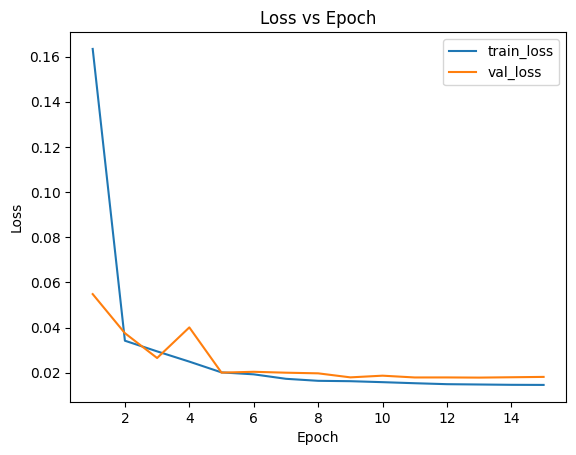

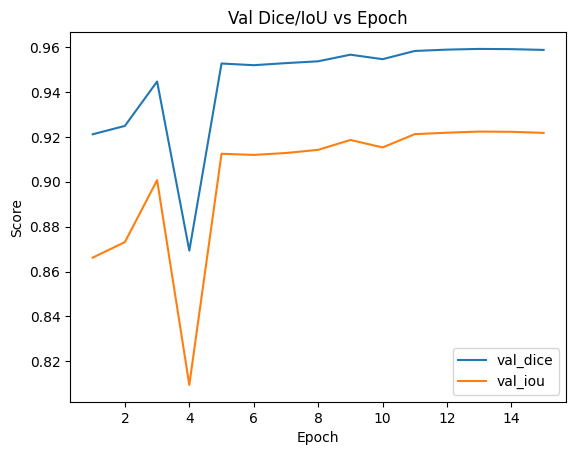

TEST | loss=0.0179 | dice=0.9606 | iou=0.9249


In [22]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader
from transformers import AutoImageProcessor, SegformerForSemanticSegmentation, get_scheduler
from torch.optim import AdamW

# -----------------------
# 1) Load processor + model (binary head)
# -----------------------
model_id = "nvidia/segformer-b3-finetuned-ade-512-512"
processor = AutoImageProcessor.from_pretrained(model_id)

id2label = {0: "background", 1: "cell"}
label2id = {"background": 0, "cell": 1}

model = SegformerForSemanticSegmentation.from_pretrained(
    model_id,
    num_labels=2,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# -----------------------
# -----------------------
for p in model.parameters():
    p.requires_grad = True

# This is the last layer producing class logits
for p in model.decode_head.classifier.parameters():
    p.requires_grad = True

trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())
print(f"Trainable params: {trainable:,} / {total:,} ({100*trainable/total:.4f}%)")

# -----------------------
# 3) Collate: PIL + mask -> pixel_values + labels (fixed 512x512)
# -----------------------
def collate_fn_hf(batch, out_h=512, out_w=512):
    images, masks, metas = zip(*batch)

    enc = processor(
        images=list(images),
        return_tensors="pt",
        size={"height": out_h, "width": out_w},
    )
    pixel_values = enc["pixel_values"]  # (B,3,H,W)

    labels = []
    for m in masks:
        m_np = m.numpy().astype(np.uint8)  # (H0,W0) 0/1
        m_img = Image.fromarray(m_np)
        m_img = m_img.resize((out_w, out_h), resample=Image.NEAREST)
        labels.append(torch.from_numpy(np.array(m_img, dtype=np.int64)))
    labels = torch.stack(labels, dim=0)  # (B,H,W)

    return {"pixel_values": pixel_values, "labels": labels, "metas": list(metas)}

batch_size = 8
num_workers = 2  # set 0 if Colab workers annoy you

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=True, collate_fn=collate_fn_hf)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True, collate_fn=collate_fn_hf)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True, collate_fn=collate_fn_hf)

# -----------------------
# 4) Metrics: upsample logits -> label size before argmax
# -----------------------
def dice_iou_from_logits(logits, labels, eps=1e-7):
    """
    logits: (B,2,h,w)   (often lower-res, e.g., 128x128)
    labels: (B,H,W)     (here 512x512)
    """
    H, W = labels.shape[-2], labels.shape[-1]
    if logits.shape[-2] != H or logits.shape[-1] != W:
        logits = F.interpolate(logits, size=(H, W), mode="bilinear", align_corners=False)

    preds = torch.argmax(logits, dim=1)  # (B,H,W)
    preds = (preds == 1).float()
    targets = (labels == 1).float()

    tp = (preds * targets).sum(dim=(1, 2))
    fp = (preds * (1 - targets)).sum(dim=(1, 2))
    fn = ((1 - preds) * targets).sum(dim=(1, 2))

    dice = (2 * tp + eps) / (2 * tp + fp + fn + eps)
    iou  = (tp + eps) / (tp + fp + fn + eps)
    return dice.mean().item(), iou.mean().item()

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    loss_sum, dice_sum, iou_sum, n = 0.0, 0.0, 0.0, 0

    for batch in loader:
        pixel_values = batch["pixel_values"].to(device, non_blocking=True)
        labels = batch["labels"].to(device, non_blocking=True)

        outputs = model(pixel_values=pixel_values, labels=labels)
        loss = outputs.loss

        dice, iou = dice_iou_from_logits(outputs.logits, labels)

        bs = pixel_values.size(0)
        loss_sum += loss.item() * bs
        dice_sum += dice * bs
        iou_sum  += iou * bs
        n += bs

    return loss_sum / max(n, 1), dice_sum / max(n, 1), iou_sum / max(n, 1)

# -----------------------
# 5) Train loop (only classifier layer updates) + store curves
# -----------------------
epochs = 15
lr = 1e-3
weight_decay = 0.0

optimizer = AdamW([p for p in model.parameters() if p.requires_grad], lr=lr, weight_decay=weight_decay)

num_training_steps = epochs * len(train_loader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=int(0.1 * num_training_steps),
    num_training_steps=num_training_steps
)

train_losses, val_losses, val_dices, val_ious = [], [], [], []

best_val_dice = -1.0
best_path = "/content/segformer_wbc_best_lastlayer.pt"

for epoch in range(1, epochs + 1):
    model.train()
    running_loss, seen = 0.0, 0

    for batch in train_loader:
        pixel_values = batch["pixel_values"].to(device, non_blocking=True)
        labels = batch["labels"].to(device, non_blocking=True)

        outputs = model(pixel_values=pixel_values, labels=labels)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        bs = pixel_values.size(0)
        running_loss += loss.item() * bs
        seen += bs

    train_loss = running_loss / max(seen, 1)
    val_loss, val_dice, val_iou = evaluate(model, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_dices.append(val_dice)
    val_ious.append(val_iou)

    print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_dice={val_dice:.4f} | val_iou={val_iou:.4f}")

    if val_dice > best_val_dice:
        best_val_dice = val_dice
        torch.save(model.state_dict(), best_path)
        print(f"  ✅ Saved best -> {best_path}")

print("Best val dice:", best_val_dice)

# -----------------------
# 6) Plot loss vs epoch
# -----------------------
x = list(range(1, epochs + 1))

plt.figure()
plt.plot(x, train_losses, label="train_loss")
plt.plot(x, val_losses, label="val_loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss vs Epoch")
plt.legend(); plt.show()

plt.figure()
plt.plot(x, val_dices, label="val_dice")
plt.plot(x, val_ious, label="val_iou")
plt.xlabel("Epoch"); plt.ylabel("Score"); plt.title("Val Dice/IoU vs Epoch")
plt.legend(); plt.show()

# -----------------------
# 7) Test evaluation (best checkpoint)
# -----------------------
model.load_state_dict(torch.load(best_path, map_location=device))
test_loss, test_dice, test_iou = evaluate(model, test_loader)
print(f"TEST | loss={test_loss:.4f} | dice={test_dice:.4f} | iou={test_iou:.4f}")


In [25]:
import gc, torch
gc.collect()
torch.cuda.empty_cache()
print("CUDA memory freed (cache).")


CUDA memory freed (cache).


Resolved image_root: /content/Wbc/original_images/original_images
Resolved mask_root : /content/Wbc/binary_masks/binary_masks
Total samples: 1560
Classes: ['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']
Train/Val/Test: 936 312 312


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b3-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([2, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded checkpoint: /content/segformer_wbc_best_lastlayer.pt
=== TEST SET SUMMARY ===
Dice: {'mean': 0.9605671541813092, 'std': 0.02225631955233211, 'median': 0.9673106074333191, 'q25': 0.957987442612648, 'q75': 0.9725549966096878, 'min': 0.7985072135925293, 'max': 0.9816397428512573}
IoU : {'mean': 0.9249467868835498, 'std': 0.038378408486084294, 'median': 0.9366907775402069, 'q25': 0.9193626195192337, 'q75': 0.9465761929750443, 'min': 0.6645959615707397, 'max': 0.9639415144920349}
Prec: {'mean': 0.9757166157166163, 'std': 0.034125335208072254, 'median': 0.9838987588882446, 'q25': 0.9741802364587784, 'q75': 0.9909787029027939, 'min': 0.7065942287445068, 'max': 0.9990022778511047}
Rec : {'mean': 0.9468479725794915, 'std': 0.024686780534884985, 'median': 0.9511266052722931, 'q25': 0.9386798292398453, 'q75': 0.9647278785705566, 'min': 0.8236910700798035, 'max': 0.9861448407173157}
Shapiro–Wilk p-value (Dice, n=312): 5.5823e-25
Wilcoxon vs Dice=0.5 p-value: 6.6282e-53
Dice 95% CI (bootstra

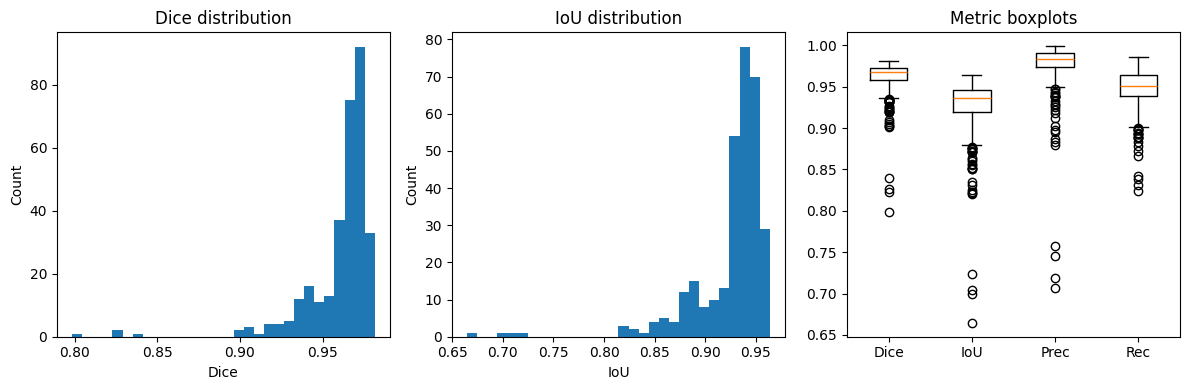

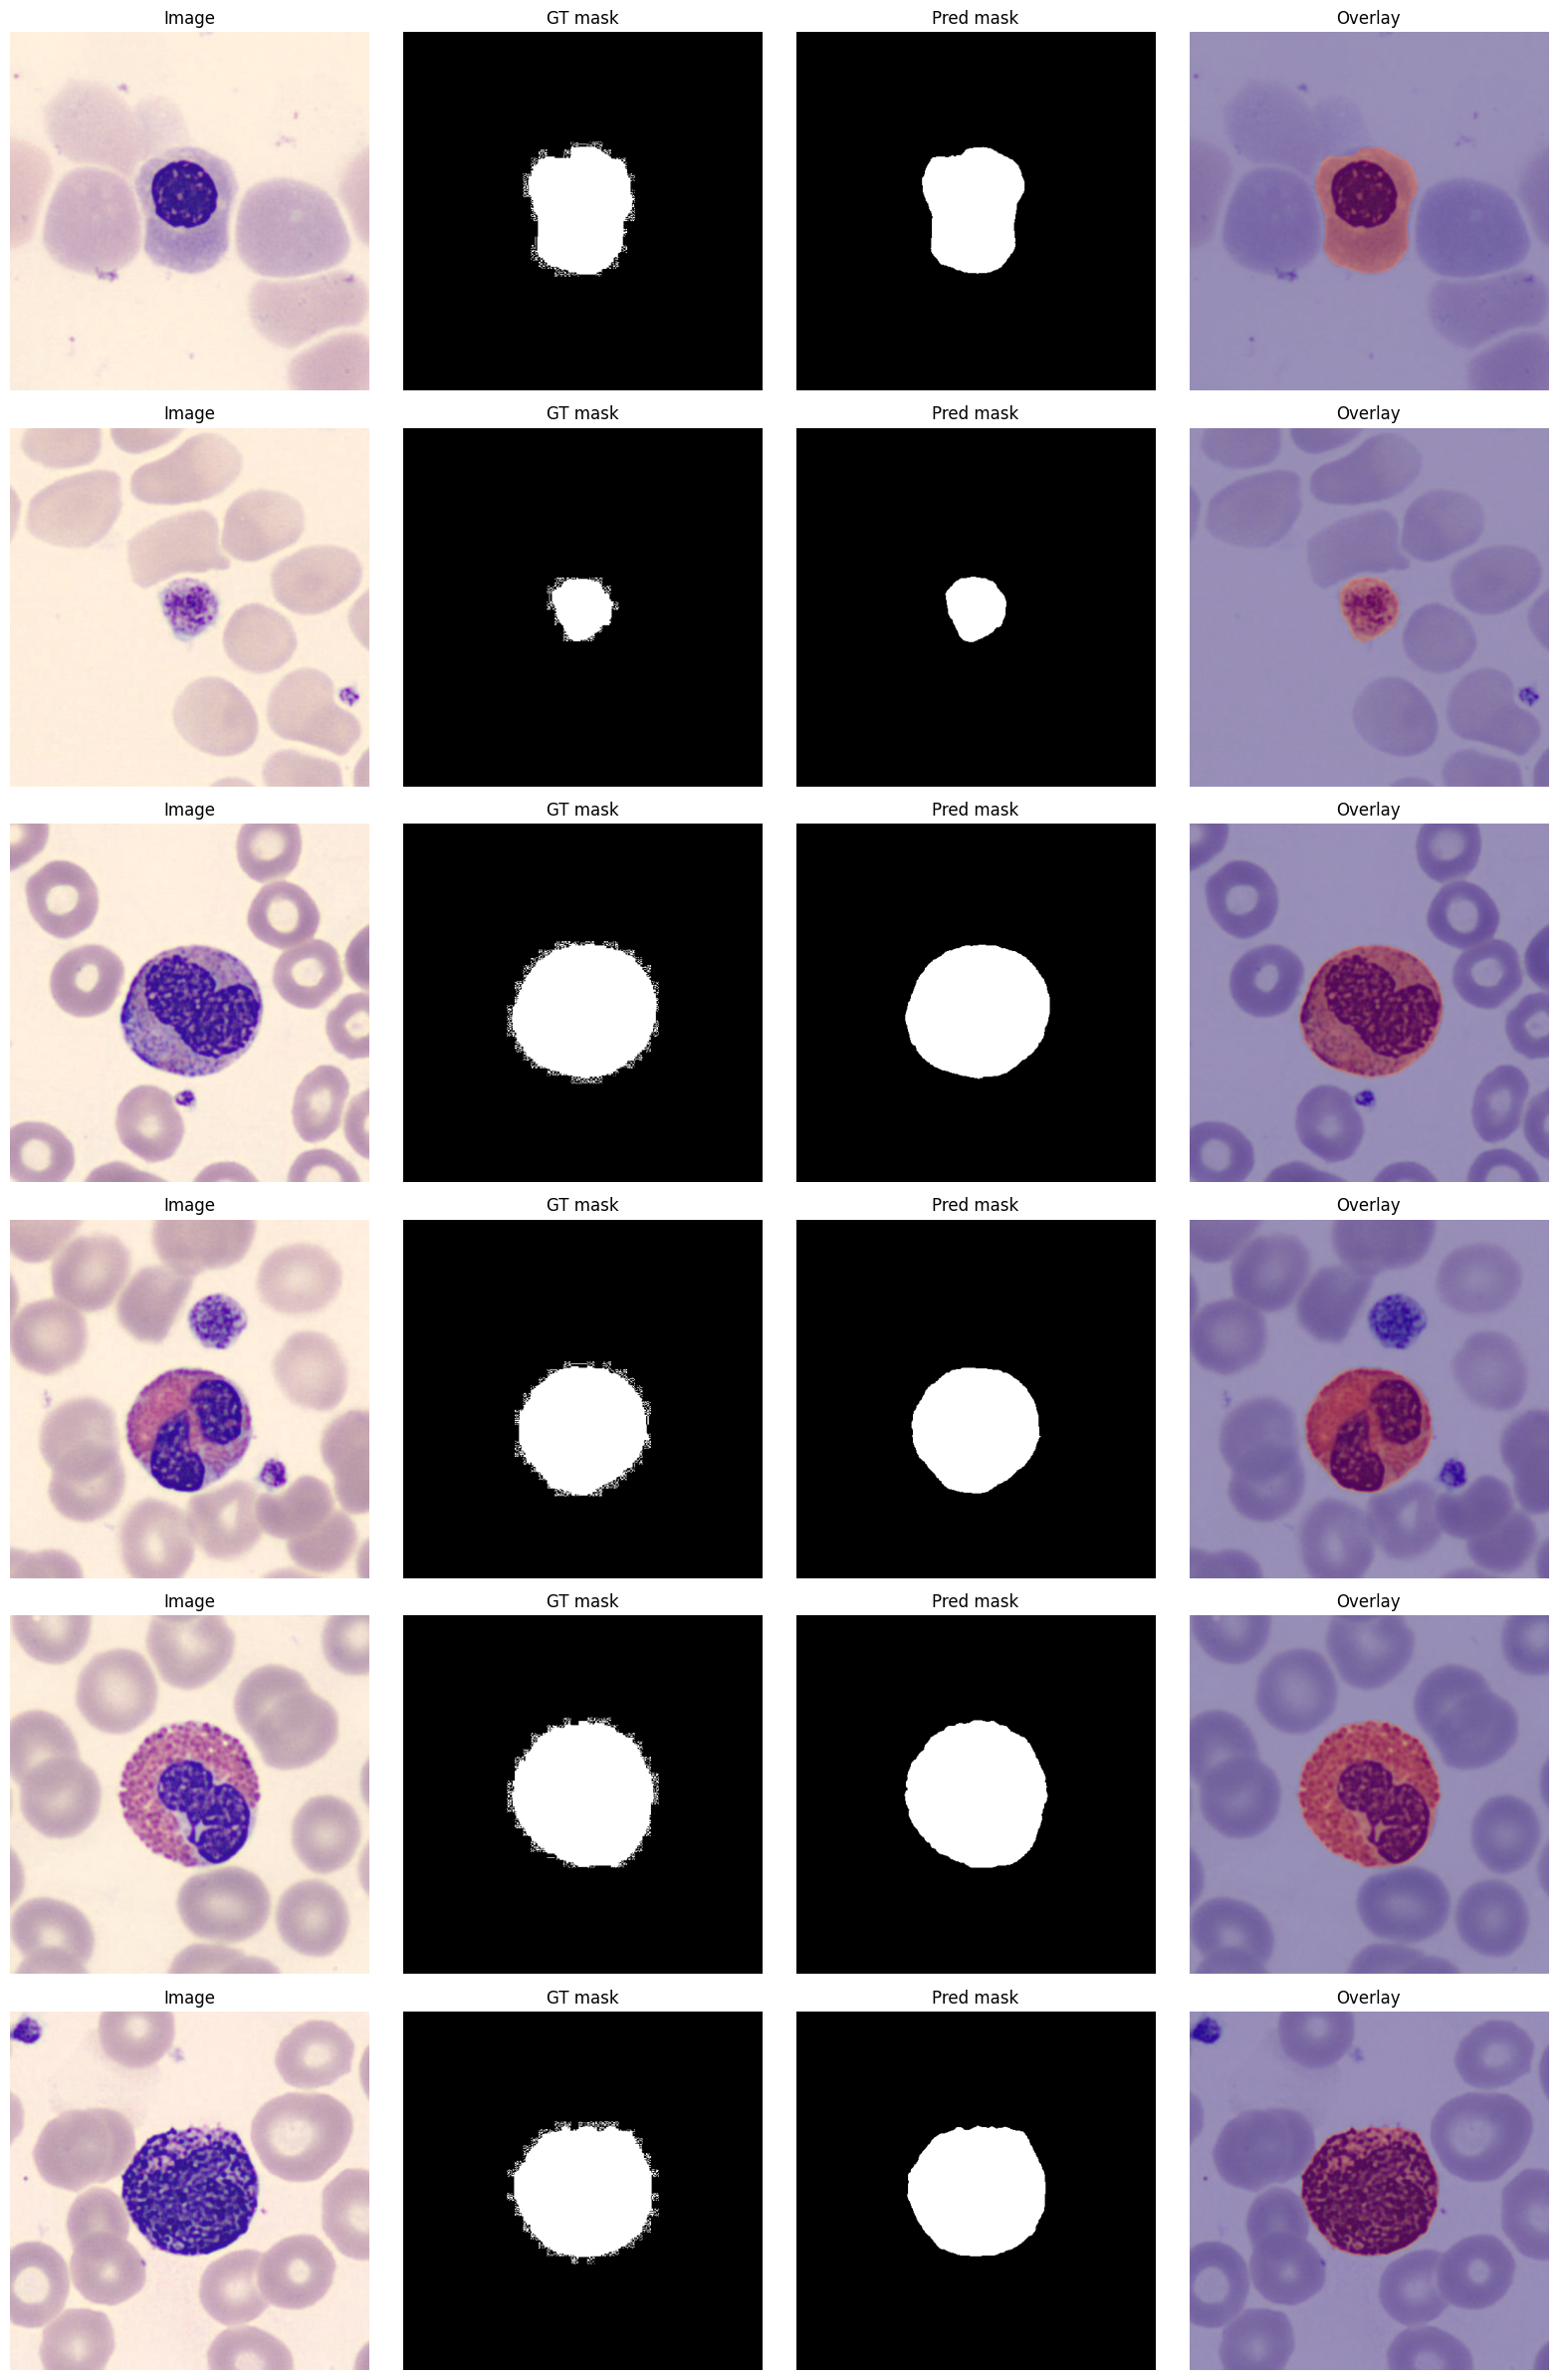

In [ ]:

!pip -q install -U transformers accelerate datasets evaluate torchvision albumentations opencv-python scipy

import os, glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from transformers import AutoImageProcessor, SegformerForSemanticSegmentation
from scipy import stats

# -----------------------
# 0) EDIT THESE PATHS
# -----------------------
ROOT_DIR  = "/content/Wbc"  # <-- change if needed
CKPT_PATH = "/content/segformer_wbc_best_lastlayer.pt"  # <-- change to your best checkpoint path

# -----------------------
# 1) Resolve the double-nested folders (original_images/original_images, binary_masks/binary_masks)
# -----------------------
def _resolve_nested(root_dir, folder_name):
    p1 = os.path.join(root_dir, folder_name)
    p2 = os.path.join(p1, folder_name)

    def has_subdirs(p):
        return os.path.isdir(p) and any(os.path.isdir(os.path.join(p, d)) for d in os.listdir(p))

    if has_subdirs(p2):
        return p2
    if has_subdirs(p1):
        return p1
    raise FileNotFoundError(f"Could not resolve {folder_name}. Checked {p1} and {p2}")

class WBCBinarySegDataset(Dataset):
    def __init__(self, root_dir, image_folder="original_images", mask_folder="binary_masks"):
        self.image_root = _resolve_nested(root_dir, image_folder)
        self.mask_root  = _resolve_nested(root_dir, mask_folder)

        self.class_names = sorted([
            d for d in os.listdir(self.image_root)
            if os.path.isdir(os.path.join(self.image_root, d))
        ])

        exts = ["png","jpg","jpeg","tif","tiff","bmp"]
        self.samples = []

        for cname in self.class_names:
            img_dir = os.path.join(self.image_root, cname)
            msk_dir = os.path.join(self.mask_root, cname)

            img_paths = []
            for e in exts:
                img_paths += glob.glob(os.path.join(img_dir, f"*.{e}"))
                img_paths += glob.glob(os.path.join(img_dir, f"*.{e.upper()}"))
            img_paths = sorted(img_paths)

            for img_path in img_paths:
                fname = os.path.basename(img_path)
                mask_path = os.path.join(msk_dir, fname)
                if not os.path.exists(mask_path):
                    raise FileNotFoundError(f"Missing mask for {img_path} -> {mask_path}")
                self.samples.append((img_path, mask_path, cname))

        if len(self.samples) == 0:
            raise RuntimeError("No samples found.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, mask_path, cname = self.samples[idx]
        image = Image.open(img_path).convert("RGB")

        mask = Image.open(mask_path)
        mask_np = np.array(mask)
        if mask_np.ndim == 3:
            mask_np = mask_np[..., 0]
        mask_np = (mask_np > 0).astype(np.int64)  # binary 0/1
        mask_t = torch.from_numpy(mask_np)

        meta = {"img_path": img_path, "mask_path": mask_path, "class_name": cname}
        return image, mask_t, meta

ds = WBCBinarySegDataset(ROOT_DIR)
print("Resolved image_root:", ds.image_root)
print("Resolved mask_root :", ds.mask_root)
print("Total samples:", len(ds))
print("Classes:", ds.class_names)

# -----------------------
# 2) 60/20/20 split (reproducible)
# -----------------------
def split_indices(n, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2, seed=42):
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-9
    rng = np.random.default_rng(seed)
    idx = np.arange(n)
    rng.shuffle(idx)
    n_train = int(n * train_ratio)
    n_val   = int(n * val_ratio)
    train_idx = idx[:n_train]
    val_idx   = idx[n_train:n_train+n_val]
    test_idx  = idx[n_train+n_val:]
    return train_idx, val_idx, test_idx

train_idx, val_idx, test_idx = split_indices(len(ds), 0.6, 0.2, 0.2, seed=42)
train_ds = Subset(ds, train_idx)
val_ds   = Subset(ds, val_idx)
test_ds  = Subset(ds, test_idx)
print("Train/Val/Test:", len(train_ds), len(val_ds), len(test_ds))

# -----------------------
# 3) HF processor + model (binary head) + load checkpoint
# -----------------------
model_id = "nvidia/segformer-b3-finetuned-ade-512-512"
processor = AutoImageProcessor.from_pretrained(model_id)

id2label = {0: "background", 1: "cell"}
label2id = {"background": 0, "cell": 1}

model = SegformerForSemanticSegmentation.from_pretrained(
    model_id,
    num_labels=2,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

device = "cuda" if torch.cuda.is_available() else "cpu"
assert device == "cuda", "GPU not available — change runtime to GPU (Runtime → Change runtime type)."
model.to(device)

# Load weights
state = torch.load(CKPT_PATH, map_location="cpu")
model.load_state_dict(state)
model.eval()
print("Loaded checkpoint:", CKPT_PATH)

# -----------------------
# 4) Collate: PIL+mask -> pixel_values+labels (fixed size)
# -----------------------
def collate_fn_hf(batch, out_h=512, out_w=512):
    images, masks, metas = zip(*batch)
    enc = processor(images=list(images), return_tensors="pt", size={"height": out_h, "width": out_w})
    pixel_values = enc["pixel_values"]  # (B,3,H,W)

    labels = []
    for m in masks:
        m_np = m.numpy().astype(np.uint8)
        m_img = Image.fromarray(m_np).resize((out_w, out_h), resample=Image.NEAREST)
        labels.append(torch.from_numpy(np.array(m_img, dtype=np.int64)))
    labels = torch.stack(labels, dim=0)  # (B,H,W)

    return {"pixel_values": pixel_values, "labels": labels, "metas": list(metas)}

# Fast GPU inference loader
test_loader = DataLoader(
    test_ds,
    batch_size=8,          # adjust if you want
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    collate_fn=collate_fn_hf
)

# -----------------------
# 5) Fast GPU inference + per-image metrics
# -----------------------
@torch.inference_mode()
def infer_test(model, loader):
    dice_vals, iou_vals, prec_vals, rec_vals = [], [], [], []
    all_preds, all_targets, all_images = [], [], []

    for batch in loader:
        x = batch["pixel_values"].to(device, non_blocking=True)
        y = batch["labels"].to(device, non_blocking=True)

        out = model(pixel_values=x)
        logits = out.logits  # (B,2,h,w)

        H, W = y.shape[-2], y.shape[-1]
        if logits.shape[-2:] != (H, W):
            logits = F.interpolate(logits, size=(H, W), mode="bilinear", align_corners=False)

        pred_ids = torch.argmax(logits, dim=1)  # (B,H,W)
        preds = (pred_ids == 1).float()
        targets = (y == 1).float()
        eps = 1e-7

        tp = (preds * targets).sum(dim=(1,2))
        fp = (preds * (1 - targets)).sum(dim=(1,2))
        fn = ((1 - preds) * targets).sum(dim=(1,2))

        dice = (2*tp + eps) / (2*tp + fp + fn + eps)
        iou  = (tp + eps) / (tp + fp + fn + eps)
        prec = (tp + eps) / (tp + fp + eps)
        rec  = (tp + eps) / (tp + fn + eps)

        dice_vals += dice.detach().cpu().tolist()
        iou_vals  += iou.detach().cpu().tolist()
        prec_vals += prec.detach().cpu().tolist()
        rec_vals  += rec.detach().cpu().tolist()

        all_preds.append(pred_ids.detach().cpu())
        all_targets.append(y.detach().cpu())
        all_images.append(x.detach().cpu())

    return dice_vals, iou_vals, prec_vals, rec_vals, torch.cat(all_preds), torch.cat(all_targets), torch.cat(all_images)

dice_vals, iou_vals, prec_vals, rec_vals, all_preds, all_targets, all_images = infer_test(model, test_loader)

def summarize(vals):
    a = np.array(vals, dtype=float)
    return {
        "mean": float(a.mean()),
        "std": float(a.std()),
        "median": float(np.median(a)),
        "q25": float(np.percentile(a, 25)),
        "q75": float(np.percentile(a, 75)),
        "min": float(a.min()),
        "max": float(a.max()),
    }

print("=== TEST SET SUMMARY ===")
print("Dice:", summarize(dice_vals))
print("IoU :", summarize(iou_vals))
print("Prec:", summarize(prec_vals))
print("Rec :", summarize(rec_vals))

# Stats tests
sub = np.array(dice_vals, dtype=float)
if len(sub) > 5000:
    sub = np.random.default_rng(0).choice(sub, size=5000, replace=False)

print(f"Shapiro–Wilk p-value (Dice, n={len(sub)}): {stats.shapiro(sub).pvalue:.4e}")
print(f"Wilcoxon vs Dice=0.5 p-value: {stats.wilcoxon(np.array(dice_vals) - 0.5).pvalue:.4e}")

def bootstrap_ci_mean(data, n=2000, alpha=0.05, seed=42):
    rng = np.random.default_rng(seed)
    data = np.array(data, dtype=float)
    means = [rng.choice(data, size=len(data), replace=True).mean() for _ in range(n)]
    lo, hi = np.percentile(means, [100*alpha/2, 100*(1-alpha/2)])
    return float(lo), float(hi)

ci_low, ci_high = bootstrap_ci_mean(dice_vals)
print(f"Dice 95% CI (bootstrap mean): [{ci_low:.4f}, {ci_high:.4f}]")

# -----------------------
# 6) Plots: distributions
# -----------------------
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.hist(dice_vals, bins=30)
plt.title("Dice distribution"); plt.xlabel("Dice"); plt.ylabel("Count")

plt.subplot(1,3,2)
plt.hist(iou_vals, bins=30)
plt.title("IoU distribution"); plt.xlabel("IoU"); plt.ylabel("Count")

plt.subplot(1,3,3)
plt.boxplot([dice_vals, iou_vals, prec_vals, rec_vals],
            tick_labels=["Dice", "IoU", "Prec", "Rec"])
plt.title("Metric boxplots")

plt.tight_layout()
plt.show()

# -----------------------
# 7) Visualize image / GT / pred / overlay
# -----------------------
def to_vis_rgb(pixel_values_3hw):
    x = pixel_values_3hw.permute(1,2,0).numpy()
    x = (x - x.min()) / (x.max() - x.min() + 1e-8)
    return x

def visualize_samples(all_images, all_targets, all_preds, n=6, alpha=0.4, seed=7):
    rng = np.random.default_rng(seed)
    N = all_images.shape[0]
    n = min(n, N)
    idxs = rng.choice(N, size=n, replace=False)

    plt.figure(figsize=(16, 4*n))
    for row, idx in enumerate(idxs):
        img = to_vis_rgb(all_images[idx].cpu())
        gt  = all_targets[idx].cpu().numpy()
        pr  = all_preds[idx].cpu().numpy()

        plt.subplot(n,4,4*row+1); plt.title("Image"); plt.imshow(img); plt.axis("off")
        plt.subplot(n,4,4*row+2); plt.title("GT mask"); plt.imshow(gt, cmap="gray", vmin=0, vmax=1); plt.axis("off")
        plt.subplot(n,4,4*row+3); plt.title("Pred mask"); plt.imshow(pr, cmap="gray", vmin=0, vmax=1); plt.axis("off")
        plt.subplot(n,4,4*row+4); plt.title("Overlay"); plt.imshow(img); plt.imshow(pr, cmap="jet", alpha=alpha); plt.axis("off")

    plt.tight_layout()
    plt.show()

visualize_samples(all_images, all_targets, all_preds, n=6, alpha=0.4, seed=7)
